In [1]:
!conda install nvidia/label/cuda-12.1.1::cuda-nvcc -y
!pip install transformers datasets peft trl accelerate kaggle packaging ninja tf-keras
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install requests networkx sec_api cachetools
!pip install torch_geometric torch_sparse torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.5.0+cu121.html
!pip install torch-geometric-temporal==0.54.0
!pip install scikit-learn matplotlib faiss-cpu yfinance qdrant-client seaborn

Channels:
 - conda-forge
 - nvidia/label/cuda-12.1.1
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - nvidia/label/cuda-12.1.1::cuda-nvcc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    certifi-2025.8.3           |     pyhd8ed1ab_0         155 KB  conda-forge
    cuda-nvcc-12.1.105         |                0        52.4 MB  nvidia/label/cuda-12.1.1
    libgcc-15.1.0              |       h767d61c_4         805 KB  conda-forge
    libgcc-ng-15.1.0           |       h69a702a_4          29 KB  conda-forge
    libgomp-15.1.0             |      

In [5]:
!pip install thefuzz python-Levenshtein

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 2.4 MB/s eta 0:00:00ta 0:00:01
Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [1]:
import os
import re
import requests
import zipfile
import json
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATv2Conv
import numpy as np
import networkx as nx
import yfinance as yf
import uuid
from typing import List, Union, Optional, Dict
import pandas as pd

import time
import logging
from dataclasses import dataclass

from torch import Tensor
from qdrant_client import QdrantClient, models
from qdrant_client.models import (
    VectorParams, Distance, PointStruct, Filter, FieldCondition, Range,
    MatchValue, PayloadSchemaType
)
from transformers import AutoTokenizer, AutoModel

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SystemConfig:
    """Unified configuration settings"""
    def __init__(self):
        self.embedding_model = "intfloat/multilingual-e5-large"
        self.vector_db_dimension = 1024
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.alpha_vantage_key = 'YWQ6A107QAJ1TPQR'
        if self.alpha_vantage_key:
            logger.info(f" Alpha Vantage key configured: {self.alpha_vantage_key[:8]}...")
        else:
            logger.warning(" No Alpha Vantage key found in environment variable 'alpha_vantage'")
            
        self.embedding_dim = 1024
        self.graph_storage_path = "./financial_embeddings_db"
        self.training_epochs = 50
        self.gpu_memory_fraction = 0.85
        
        #  NEW: Hyperparameters for easier tuning 
        self.learning_rate = 0.005
        self.weight_decay = 5e-4
        
        self._setup_gpu_memory_limits()
    
    def _setup_gpu_memory_limits(self):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.set_per_process_memory_fraction(self.gpu_memory_fraction)
            logger.info(f"GPU memory limited to {self.gpu_memory_fraction*100}%")

# 
# EDGAR DATA PROCESSING AND MARKET ENRICHMENT
# 

class EDGARDataDownloader:
    """Downloads and processes SEC EDGAR bulk data"""
    
    def __init__(self, user_agent="Financial Research Bot research@example.com"):
        self.user_agent = user_agent
        self.headers = {"User-Agent": self.user_agent}
        self.base_url = "https://www.sec.gov/Archives/edgar/daily-index"
        
    def download_bulk_data(self, data_type="companyfacts", output_dir="edgar_data"):
        """Download EDGAR bulk data ZIP files"""
        urls = {
            "companyfacts": f"{self.base_url}/xbrl/companyfacts.zip",
        }
        if data_type not in urls:
            raise ValueError(f"Invalid data_type. Choose from: {list(urls.keys())}")
        
        os.makedirs(output_dir, exist_ok=True)
        url = urls[data_type]
        
        logger.info(f"Downloading {data_type} from {url}...")
        response = requests.get(url, headers=self.headers, stream=True)
        response.raise_for_status()
        
        zip_path = os.path.join(output_dir, f"{data_type}.zip")
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        extracted_dir = os.path.join(output_dir, data_type)
        os.makedirs(extracted_dir, exist_ok=True)
        
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
            
        logger.info(f"Data extracted to {extracted_dir}")
        return extracted_dir
    
    def parse_company_facts(self, extracted_dir: str, limit: Optional[int] = None) -> iter:
        """
        MODIFIED: This is now a generator function. It parses company facts 
        and yields each company's data one by one, keeping memory usage low.
        """
        json_files = sorted([f for f in os.listdir(extracted_dir) if f.endswith('.json')])
        files_to_process = json_files[:limit] if limit is not None else json_files
        
        logger.info(f"Starting to parse and yield from {len(files_to_process)} company fact files...")
        
        processed_count = 0
        for i, filename in enumerate(files_to_process):
            if (i + 1) % 2000 == 0:
                logger.info(f"  ...processed {i + 1}/{len(files_to_process)} files")
            
            filepath = os.path.join(extracted_dir, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                if not data.get('entityName') or not data.get('cik'):
                    continue
                
                company_info = {
                    'cik': str(data['cik']),
                    'entityName': data['entityName'],
                    'tickers': data.get('tickers', []),
                    'exchanges': data.get('exchanges', []),
                    'sic': data.get('sic'),
                    'sicDescription': data.get('sicDescription'),
                    'stateOfIncorporation': data.get('stateOfIncorporation'),
                    'fiscalYearEnd': data.get('fiscalYearEnd'),
                    'facts': data.get('facts', {})
                }
                yield company_info  # <<< CHANGE: Use yield instead of append
                processed_count += 1
                    
            except Exception as e:
                logger.warning(f"Skipping file {filename} due to error: {e}")
                continue
        
        logger.info(f" Successfully parsed and yielded data for {processed_count} companies.")
        
class KaggleXBRLDataEnricher:
    """
    REFACTORED: Handles a memory-efficient hybrid data enrichment stream.
    """
    def __init__(self, user_agent="Financial Research Bot research@example.com"):
        self.user_agent = user_agent
        self.api_cache = {}
        #  ADD FOR DEBUGGING 
        self.other_count = 0
        self.other_examples_shown = 0
        self.sector_samples = {}
        
        # -


    def process_and_save_data(self, output_path: str, cache_file: str = "./sec_api_cache.json"):
        """
        Main method to stream, enrich, and save company data to a .jsonl file.
        """
        # Step 1 & 2: Identify missing CIKs and update the API cache
        self._update_api_cache(cache_file)

        # Step 3: Stream from files, enrich using the cache, and write to output
        edgar_downloader = EDGARDataDownloader(user_agent=self.user_agent)
        companyfacts_dir = "edgar_data/companyfacts"
        data_generator = edgar_downloader.parse_company_facts(companyfacts_dir)
        
        processed_count = 0
        with open(output_path, 'w', encoding='utf-8') as f:
            for company in data_generator:
                enriched_company = self._enrich_single_company(company)
                f.write(json.dumps(enriched_company) + '\n')
                processed_count += 1
        
        logger.info(f" Saved {processed_count} enriched companies to '{output_path}'.")

    def _update_api_cache(self, cache_file: str):
        """
        MODIFIED: Fetches missing CIKs in batches and saves progress incrementally
        to handle rate limits and interruptions gracefully.
        """
        # Step 1: Load existing cache
        try:
            with open(cache_file, 'r') as f:
                self.api_cache = json.load(f)
            logger.info(f"Loaded {len(self.api_cache)} CIKs from API cache '{cache_file}'.")
        except (FileNotFoundError, json.JSONDecodeError):
            self.api_cache = {}
            logger.info("No existing API cache found. A new one will be created.")

        # Step 2: Identify all CIKs from the source files
        edgar_downloader = EDGARDataDownloader(user_agent=self.user_agent)
        companyfacts_dir = "edgar_data/companyfacts"
        all_ciks = {c['cik'] for c in edgar_downloader.parse_company_facts(companyfacts_dir)}
        
        # Determine which CIKs are new and need to be fetched
        ciks_to_fetch = sorted(list(all_ciks - set(self.api_cache.keys())))

        if not ciks_to_fetch:
            logger.info(" API cache is already up-to-date.")
            return

        logger.info(f"🚀 Found {len(ciks_to_fetch)} new CIKs to fetch.")

        # Step 3: Fetch in batches and save progress incrementally
        batch_size = 500
        for i in range(0, len(ciks_to_fetch), batch_size):
            batch = ciks_to_fetch[i:i+batch_size]
            logger.info(f" Processing batch {i//batch_size + 1}/{-(-len(ciks_to_fetch)//batch_size)} (CIKs {i} to {i+len(batch)-1}) ")
            
            with ThreadPoolExecutor(max_workers=4) as executor:
                # Map each future to its CIK
                future_to_cik = {executor.submit(self._fetch_sec_data_for_cik, cik): cik for cik in batch}
                
                # Process results as they complete
                for future in as_completed(future_to_cik):
                    cik = future_to_cik[future]
                    result = future.result()
                    if result:  # Only add to cache if the fetch was successful
                        self.api_cache[cik] = result
            
            # Save progress after each batch
            try:
                with open(cache_file, 'w') as f:
                    json.dump(self.api_cache, f)
                logger.info(f" Batch complete. API cache now has {len(self.api_cache)} entries.")
            except Exception as e:
                logger.error(f"Could not save API cache to '{cache_file}': {e}")

    def _fetch_sec_data_for_cik(self, cik: str) -> Optional[Dict]:
        if not cik or not str(cik).isdigit(): return None
        
        url = f"https://data.sec.gov/submissions/CIK{str(cik).zfill(10)}.json"
        headers = {'User-Agent': self.user_agent}

        #  NEW: Implement a retry mechanism with exponential backoff 
        max_retries = 5
        base_delay = 1  # Start with a 1-second delay

        for attempt in range(max_retries):
            try:
                response = requests.get(url, headers=headers)
                response.raise_for_status() # Will raise an exception for 4xx/5xx errors
                
                # Success! Pause slightly to respect rate limits even on success.
                time.sleep(0.9) 
                return response.json()

            except requests.exceptions.RequestException as e:
                # Specifically check for the "Too Many Requests" error
                if response.status_code == 429:
                    delay = base_delay * (2 ** attempt) + np.random.uniform(0, 1)
                    logger.warning(
                        f"Rate limit exceeded for CIK {cik}. "
                        f"Retrying in {delay:.2f} seconds... (Attempt {attempt + 1}/{max_retries})"
                    )
                    time.sleep(delay)
                else:
                    # For other errors (e.g., 404 Not Found), don't retry.
                    logger.warning(f"Failed to fetch data for CIK {cik}. Reason: {e}")
                    return None # Stop trying for this CIK
        
        # If all retries fail, log it and give up.
        logger.error(f"All {max_retries} retries failed for CIK {cik}. Giving up.")
        return None

    def _enrich_single_company(self, base_company: Dict) -> Dict:
        """Enriches a single company record with API data and a standardized sector."""
        api_data = self.api_cache.get(base_company['cik'])
        
        # Start with the base data from the file
        final_data = base_company
        
        # If API data exists, intelligently merge it, preferring API values
        # but falling back to the base data if a key is missing from the API response.
        if api_data:
            final_data = {
                'cik': base_company['cik'], # Keep the original CIK
                'entityName': api_data.get('name') or base_company.get('entityName'),
                'tickers': api_data.get('tickers') or base_company.get('tickers', []),
                'exchanges': api_data.get('exchanges') or base_company.get('exchanges', []),
                'sic': api_data.get('sic') or base_company.get('sic'), # <<< CRITICAL FIX HERE
                'sicDescription': api_data.get('sicDescription') or base_company.get('sicDescription'),
                'stateOfIncorporation': api_data.get('stateOfIncorporation') or base_company.get('stateOfIncorporation'),
                'fiscalYearEnd': api_data.get('fiscalYearEnd') or base_company.get('fiscalYearEnd'),
                'facts': base_company.get('facts', {}) # Always keep the detailed facts from the file
            }

        sector = 'Other'
        sic_code_str = final_data.get('sic')
        if sic_code_str and str(sic_code_str).isdigit():
            sector = self._sic_to_sector(int(sic_code_str))
        
        # Your universal sample collection logic (no changes needed here)
        if sector not in self.sector_samples:
            self.sector_samples[sector] = []
        
        if len(self.sector_samples[sector]) < 5:
            sample_info = f"Name: '{final_data.get('entityName', 'N/A')}', SIC: {sic_code_str}"
            self.sector_samples[sector].append(sample_info)

        final_data['market_data'] = {
            'sector': sector, 'industry': final_data.get('sicDescription', ''),
            'data_source': 'edgar_hybrid'
        }
        return final_data
        
    def _sic_to_sector(self, sic_code: int) -> str:
        # This function remains the same as before
        if not sic_code or not 100 <= sic_code <= 9999: return 'Other'
        if 2836 == sic_code: return 'Biotechnology'
        if 5961 == sic_code: return 'E-commerce'
        if 100 <= sic_code <= 999: return 'Agriculture'
        if 1000 <= sic_code <= 1499: return 'Mining'
        if 1500 <= sic_code <= 1799: return 'Construction'
        if 2000 <= sic_code <= 3999:
            tech_mfg = [(3570, 3579), (3600, 3699), (3812, 3812), (3823, 3829), (3840, 3849)]
            if any(s <= sic_code <= e for s, e in tech_mfg): return 'Technology'
            if 2834 <= sic_code <= 2836: return 'Healthcare'
            return 'Manufacturing'
        if 4000 <= sic_code <= 4999:
            if 4800 <= sic_code <= 4899: return 'Technology'
            return 'Transportation & Public Utilities'
        if 5000 <= sic_code <= 5199: return 'Wholesale Trade'
        if 5200 <= sic_code <= 5999: return 'Retail Trade'
        if 6000 <= sic_code <= 6799: return 'Financial Services'
        if 7000 <= sic_code <= 8999:
            tech_svc = [(7370, 7379), (7380, 7389), (8711, 8711), (8748, 8748)]
            if any(s <= sic_code <= e for s, e in tech_svc): return 'Technology'
            if 8000 <= sic_code <= 8099: return 'Healthcare'
            ent_media = [(7800, 7841), (4830, 4841)]
            if any(s <= sic_code <= e for s, e in ent_media): return 'Entertainment & Media'
            return 'Services'
        if 9100 <= sic_code <= 9729: return 'Public Administration'
        return 'Other'


# 
# ENHANCED KNOWLEDGE GRAPH CONSTRUCTION
# 

class EnhancedFinancialKnowledgeGraph:
    """
    REFACTORED: This version is designed to be built entirely from a data stream
    to handle datasets that are larger than available RAM.
    """
    
    def __init__(self):
        self.graph = nx.DiGraph()
        self.entity_attributes = {}
        self.relationship_types = set()
        self.feature_names = [
            'type_company', 'type_metric', 'type_industry', 'type_market_metric',
            'total_assets', 'revenues', 'net_income', 'stockholders_equity',
            'mkt_current_price', 'mkt_market_cap', 'mkt_pe_ratio', 'mkt_pb_ratio',
            'mkt_dividend_yield', 'mkt_beta', 'mkt_return_on_equity', 'mkt_debt_to_equity',
            'sic_numeric', 'num_exchanges', 'num_tickers'
        ]
        self.feature_map = {name: i for i, name in enumerate(self.feature_names)}
        self.industry_to_companies = {}

    def build_graph_from_stream(self, companies_data_generator: iter):
        """
        NEW: Builds the graph in two passes directly from the stream.
        Pass 1 adds all nodes. Pass 2 adds complex edges that require global context.
        """
        #  PASS 1: Add all nodes and their attributes from the stream 
        logger.info("Building graph - Pass 1/2: Streaming and adding all nodes...")
        for company in companies_data_generator:
            self._add_company_node(company)
            # Also add simple, single-company relationships during this pass
            self._add_financial_relationships(company)
            self._add_industry_relationships(company)
            self._add_market_relationships(company)
        
        logger.info(f"Pass 1 complete. Graph has {self.graph.number_of_nodes()} nodes.")

        #  PASS 2: Add relationships that require all nodes to be present 
        logger.info("Building graph - Pass 2/2: Adding peer and market cap relationships...")
        self._group_companies_by_industry_from_graph() # This now works on the graph itself
        self._add_peer_relationships()
        self._add_market_cap_relationships()
        
        logger.info(f"Built graph with {self.graph.number_of_nodes()} nodes and {self.graph.number_of_edges()} edges.")
        self._analyze_graph_connectivity()

    def _group_companies_by_industry_from_graph(self):
        """NEW: Groups companies by iterating over the graph nodes, not a list."""
        logger.info("Grouping companies by sector directly from graph nodes...")
        for node_id, attrs in self.graph.nodes(data=True):
            if attrs.get('type') == 'company':
                sector = attrs.get('sector', 'Other')
                if sector not in self.industry_to_companies:
                    self.industry_to_companies[sector] = []
                self.industry_to_companies[sector].append(node_id)
        
        total_grouped = sum(len(c) for c in self.industry_to_companies.values())
        logger.info(f"Grouped {total_grouped} companies into {len(self.industry_to_companies)} sectors.")
    
    def _analyze_graph_connectivity(self):
        """Analyze and report graph connectivity"""
        
        if self.graph.number_of_nodes() == 0:
            logger.warning("Graph is empty!")
            return
        
        # Convert to undirected for connectivity analysis
        undirected = self.graph.to_undirected()
        
        # Find connected components
        components = list(nx.connected_components(undirected))
        largest_component = max(components, key=len) if components else set()
        
        logger.info(f"Graph connectivity analysis:")
        logger.info(f"  Total nodes: {self.graph.number_of_nodes()}")
        logger.info(f"  Total edges: {self.graph.number_of_edges()}")
        logger.info(f"  Connected components: {len(components)}")
        logger.info(f"  Largest component size: {len(largest_component)} ({len(largest_component)/self.graph.number_of_nodes()*100:.1f}%)")
        
        if len(components) > 1:
            logger.warning(f"Graph has {len(components)} disconnected components!")
            component_sizes = sorted([len(comp) for comp in components], reverse=True)
            logger.info(f"  Component sizes: {component_sizes[:10]}")  # Show top 10

            
    def _add_company_node(self, company):
        """
        MODIFIED: Adds a company node but no longer stores the huge raw 'facts' 
        dictionary as a node attribute to save significant memory.
        """
        cik = str(company['cik'])
        entity_name = company['entityName']
        market_data = company.get('market_data', {})
        
        # This is the raw financial data, which can be very large
        facts = company.get('facts', {})
        
        # We extract the necessary numerical metrics from 'facts'
        financial_attrs = self._extract_financial_metrics(facts)
        market_attrs = self._process_market_attributes(market_data)

        node_attrs = {
            'type': 'company',
            'name': entity_name,
            'cik': cik,
            'sector': market_data.get('sector', 'Other'), 
            'tickers': company.get('tickers', []),
            'sic': company.get('sic', ''),
            'sic_description': company.get('sicDescription', ''),
            'state': company.get('stateOfIncorporation', ''),
            'fiscal_year_end': company.get('fiscalYearEnd', ''),
            'exchanges': company.get('exchanges', [])
        }
        
        # Add the extracted financial and market metrics
        node_attrs.update(financial_attrs)
        node_attrs.update(market_attrs)
        
        # CRITICAL CHANGE: We DO NOT add the raw 'facts' object to the node.
        # The 'financial_attrs' already contain everything we need for GNN features.
        
        self.graph.add_node(cik, **node_attrs)
        self.entity_attributes[cik] = node_attrs


    def _add_peer_relationships(self):
        """
        Adds peer relationships using a capped random sampling strategy
        for ALL sectors to prevent combinatorial explosion and over-density.
        """
        logger.info(f"Creating peer-to-peer edges for {len(self.industry_to_companies)} industries...")
        edge_count = 0
        # Set a hard limit on connections per company to keep the graph sparse
        max_connections_per_company = 15 
        
        import random
        
        for sector, companies in self.industry_to_companies.items():
            if len(companies) <= 1:
                continue
            
            logger.info(f"  Processing {sector} with {len(companies)} companies")
            
            # Apply the same safe, sampling logic to every sector
            for company in companies:
                # Find potential peers (all other companies in the sector)
                peers = [c for c in companies if c != company]
                
                # Determine how many connections to make
                num_to_connect = min(max_connections_per_company, len(peers))
                selected_peers = random.sample(peers, num_to_connect)
                
                for peer in selected_peers:
                    # Add a single directed edge (will be treated as undirected by GNNs later)
                    if not self.graph.has_edge(company, peer):
                        self.graph.add_edge(company, peer, relationship='peer_of')
                        edge_count += 1
                        
        self.relationship_types.add('peer_of')
        logger.info(f"Added {edge_count} 'peer_of' edges to the graph.")

    
    def _add_market_cap_relationships(self):
        """Add relationships between companies of similar market cap"""
        
        logger.info("Adding market cap similarity relationships...")
        
        # Group companies by market cap ranges
        cap_ranges = {
            'mega_cap': [],    # > 200B
            'large_cap': [],   # 10B - 200B  
            'mid_cap': [],     # 2B - 10B
            'small_cap': []    # < 2B
        }
        
        for node_id, attrs in self.graph.nodes(data=True):
            if attrs.get('type') == 'company':
                market_cap = attrs.get('mkt_market_cap', 0)
                
                if market_cap > 200e9:
                    cap_ranges['mega_cap'].append(node_id)
                elif market_cap > 10e9:
                    cap_ranges['large_cap'].append(node_id)
                elif market_cap > 2e9:
                    cap_ranges['mid_cap'].append(node_id)
                else:
                    cap_ranges['small_cap'].append(node_id)
        
        # Create connections within each market cap range
        edge_count = 0
        for cap_range, companies in cap_ranges.items():
            if len(companies) > 1:
                # Connect each company to a few others in the same cap range
                import random
                for company in companies:
                    peers = [c for c in companies if c != company]
                    selected_peers = random.sample(peers, min(5, len(peers)))
                    
                    for peer in selected_peers:
                        if not self.graph.has_edge(company, peer):
                            self.graph.add_edge(company, peer, relationship='similar_market_cap')
                            edge_count += 1
        
        logger.info(f"Added {edge_count} market cap similarity edges")

        
    def _extract_financial_metrics(self, facts):
        """Extract key financial metrics from SEC facts"""
        
        financial_attrs = {}
        
        # Enhanced GAAP metrics
        gaap_metrics = {
            'Assets': 'total_assets',
            'Revenues': 'revenues',
            'NetIncomeLoss': 'net_income',
            'StockholdersEquity': 'stockholders_equity',
            'CashAndCashEquivalentsAtCarryingValue': 'cash',
            'LongTermDebt': 'long_term_debt'
        }
        
        us_gaap = facts.get('us-gaap', {})
        
        for gaap_key, attr_name in gaap_metrics.items():
            if gaap_key in us_gaap:
                metric_data = us_gaap[gaap_key]
                if 'units' in metric_data and 'USD' in metric_data['units']:
                    usd_data = metric_data['units']['USD']
                    if usd_data:
                        # Get most recent annual value
                        latest_value = max(usd_data, key=lambda x: x.get('end', ''))
                        financial_attrs[attr_name] = latest_value.get('val', 0)
        
        return financial_attrs
    
    def _process_market_attributes(self, market_data):
        """Process and normalize market data attributes"""
        
        market_attrs = {}
        
        # Direct market attributes
        market_fields = [
            'current_price', 'market_cap', 'pe_ratio', 'pb_ratio',
            'dividend_yield', 'beta', 'profit_margins',
            'return_on_equity', 'debt_to_equity', 'revenue_growth',
            'year_return'
        ]
        
        for field in market_fields:
            value = market_data.get(field, 0)
            # Handle None values and convert to float
            if value is not None and value != '':
                try:
                    market_attrs[f"mkt_{field}"] = float(value)
                except (ValueError, TypeError):
                    market_attrs[f"mkt_{field}"] = 0.0
            else:
                market_attrs[f"mkt_{field}"] = 0.0
        
        return market_attrs
    
    def _add_market_relationships(self, company):
        """Add market data relationships and nodes"""
        
        cik = str(company['cik'])
        market_data = company.get('market_data', {})
        tickers = company.get('tickers', [])
        
        if not tickers or not market_data:
            return
            
        ticker = tickers[0]
        
        # Add price node
        current_price = market_data.get('current_price', 0)
        if current_price and current_price > 0:
            price_node = f"price_{ticker}"
            if not self.graph.has_node(price_node):
                self.graph.add_node(price_node, 
                                  type='market_metric',
                                  metric='current_price',
                                  value=current_price,
                                  ticker=ticker)
            self.graph.add_edge(cik, price_node, relationship='has_price')
            self.relationship_types.add('has_price')
    
    def _add_financial_relationships(self, company):
        """Add financial relationships based on metrics"""
        
        cik = str(company['cik'])
        facts = company.get('facts', {})
        
        # Add metric nodes and relationships
        us_gaap = facts.get('us-gaap', {})
        for metric_name, metric_data in list(us_gaap.items())[:5]:  # Limit to avoid too many nodes
            if 'units' in metric_data:
                metric_node = f"metric_{metric_name}"
                
                if not self.graph.has_node(metric_node):
                    self.graph.add_node(metric_node, type='metric', name=metric_name)
                
                self.graph.add_edge(cik, metric_node, relationship='reports')
                self.relationship_types.add('reports')
                
    def _add_industry_relationships(self, company):
        """Add industry-based relationships"""
        
        cik = str(company['cik'])
        sic = company.get('sic', '')
        sic_description = company.get('sicDescription', '')
        
        if sic and sic_description:
            industry_node = f"industry_{sic}"
            
            if not self.graph.has_node(industry_node):
                self.graph.add_node(industry_node, 
                                  type='industry', 
                                  sic=sic, 
                                  description=sic_description)
            
            self.graph.add_edge(cik, industry_node, relationship='belongs_to')
            self.relationship_types.add('belongs_to')
    
    def get_enhanced_node_features(self, node_id):
        """
        Extracts enhanced numerical features for a node in a consistent, predefined order.
        """
        # 1. Handle nodes that might not be in the graph (e.g., during edge cases)
        if node_id not in self.graph.nodes:
            return np.zeros(len(self.feature_names), dtype=np.float32)
    
        attrs = self.graph.nodes[node_id]
        features_dict = {}  # Build features in a dictionary for robustness
    
        # 2. Type encoding (one-hot)
        node_type = attrs.get('type', 'unknown')
        features_dict['type_company'] = 1.0 if node_type == 'company' else 0.0
        features_dict['type_metric'] = 1.0 if node_type == 'metric' else 0.0
        features_dict['type_industry'] = 1.0 if node_type == 'industry' else 0.0
        features_dict['type_market_metric'] = 1.0 if node_type == 'market_metric' else 0.0
    
        # 3. SEC financial metrics (log-normalized to handle large value ranges)
        sec_metrics = ['total_assets', 'revenues', 'net_income', 'stockholders_equity']
        for metric in sec_metrics:
            value = float(attrs.get(metric, 0.0))
            features_dict[metric] = np.log1p(max(0, value))
    
        # 4. Market data features (with specific normalization)
        market_metrics = [
            'mkt_current_price', 'mkt_market_cap', 'mkt_pe_ratio', 'mkt_pb_ratio',
            'mkt_dividend_yield', 'mkt_beta', 'mkt_return_on_equity', 'mkt_debt_to_equity'
        ]
        for metric in market_metrics:
            value = float(attrs.get(metric, 0.0))
            if 'ratio' in metric or 'yield' in metric:
                normalized_value = max(-1.0, min(1.0, value))
            elif 'price' in metric or 'cap' in metric:
                normalized_value = np.log1p(max(0, value))
            else: # Covers beta and other metrics
                normalized_value = max(-3.0, min(3.0, value))
            features_dict[metric] = normalized_value
            
        # 5. SIC code encoding (normalized)
        #    Handle cases where 'sic' can be None or an integer. The original code
        #      failed with an AttributeError if attrs.get('sic') returned None.
        sic_raw = attrs.get('sic') 
        # Safely convert the raw value to a string. None becomes an empty string ''.
        sic = str(sic_raw) if sic_raw is not None else ''
        
        # Now that `sic` is guaranteed to be a string, this check is safe.
        sic_numeric = float(sic) if sic.isdigit() else 0.0
        features_dict['sic_numeric'] = sic_numeric / 10000.0
    
        # 6. Categorical counts
        features_dict['num_exchanges'] = float(len(attrs.get('exchanges', [])))
        features_dict['num_tickers'] = float(len(attrs.get('tickers', [])))
    
        # 7. Assemble the final feature vector in the correct order
        # This is the most important step for robustness. It uses the predefined
        # list to order the features and provides a default of 0.0 if a key is missing.
        final_features = [features_dict.get(name, 0.0) for name in self.feature_names]
        
        return np.array(final_features, dtype=np.float32)

# 
# GRAPHSAGE EMBEDDINGS AND TRAINING
# 

class MultilingualE5Embedder:
    """
    Multilingual-E5-Large embedder using transformers library
    Replaces SentenceTransformer with better performance and 1024-dimensional outputs
    """
    
    def __init__(self, model_name='intfloat/multilingual-e5-large', device=None):
        self.model_name = model_name
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        
        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,  # Use fp16 to save memory
        ).to(self.device)
        self.model.eval()
        
        logger.info(f"Loaded {model_name} on {self.device}")
    
    def average_pool(self, last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        """Average pooling for sentence embeddings"""
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    def format_text_with_prefix(self, text: str, text_type: str = "passage") -> str:
        """Format text with appropriate E5 prefixes for optimal performance"""
        if text_type == "query":
            return f"query: {text}"
        elif text_type == "passage":
            return f"passage: {text}"
        else:
            return f"passage: {text}"  # Default to passage
    
    def encode(self, texts: Union[str, List[str]], 
               text_type: str = "passage", 
               normalize: bool = True, 
               batch_size: int = 32,
               show_progress: bool = False) -> np.ndarray:
        """
        Encode texts to embeddings with proper E5 prefixes
        
        Args:
            texts: Single text string or list of texts
            text_type: "query" or "passage" for appropriate prefixing
            normalize: Whether to normalize embeddings
            batch_size: Batch size for processing
            show_progress: Whether to show progress
        
        Returns:
            NumPy array of embeddings (N x 1024)
        """
        
        # Handle single text input
        if isinstance(texts, str):
            texts = [texts]
        
        # Format texts with prefixes
        formatted_texts = [self.format_text_with_prefix(text, text_type) for text in texts]
        
        all_embeddings = []
        
        for i in range(0, len(formatted_texts), batch_size):
            batch_texts = formatted_texts[i:i+batch_size]
            
            # Tokenize batch
            batch_dict = self.tokenizer(
                batch_texts, 
                max_length=512,  # E5 model max length
                padding=True, 
                truncation=True, 
                return_tensors='pt'
            )
            
            # Move to device
            batch_dict = {k: v.to(self.device) for k, v in batch_dict.items()}
            
            # Generate embeddings
            with torch.no_grad():
                outputs = self.model(**batch_dict)
                embeddings = self.average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
                
                if normalize:
                    embeddings = F.normalize(embeddings, p=2, dim=1)
                
                all_embeddings.append(embeddings.cpu())
            
            if show_progress and i % (batch_size * 10) == 0:
                logger.info(f"Processed {i + len(batch_texts)}/{len(formatted_texts)} texts")
        
        # Concatenate all embeddings
        final_embeddings = torch.cat(all_embeddings, dim=0)
        return final_embeddings.to(torch.float32).numpy()
    
    def encode_queries(self, queries: Union[str, List[str]], **kwargs) -> np.ndarray:
        """Encode queries with query prefix"""
        return self.encode(queries, text_type="query", **kwargs)
    
    def encode_passages(self, passages: Union[str, List[str]], **kwargs) -> np.ndarray:
        """Encode passages with passage prefix"""
        return self.encode(passages, text_type="passage", **kwargs)


# 
# ADVANCED GNN ARCHITECTURES FOR FINANCE
# 
class WorkingTemporalFinancialGNN(nn.Module):
    """
    Working temporal GNN without torch_geometric_temporal dependency
    Uses standard PyTorch components for financial time series analysis
    """
    
    def __init__(self, node_features, periods=12, hidden_dim=64, attention_heads=4):
        super().__init__()

        self.periods = periods 
        self.input_projection = nn.Linear(node_features, hidden_dim)
        self.graph_conv1 = SAGEConv(node_features, hidden_dim)
        self.graph_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.temporal_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=attention_heads, batch_first=True)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        
        # ADDED: A simple head for the feature prediction task
        self.feature_predictor = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, edge_index):
        h = F.relu(self.graph_conv1(x, edge_index))
        h = F.dropout(h, p=0.1, training=self.training)
        h = F.relu(self.graph_conv2(h, edge_index))
        
        # This line will now work correctly
        h_temporal = h.unsqueeze(1).repeat(1, self.periods, 1)
        
        lstm_out, _ = self.lstm(h_temporal)
        attended_h, _ = self.temporal_attention(lstm_out, lstm_out, lstm_out)
        temporal_features = attended_h.mean(dim=1)
        
        return {
            'embeddings': temporal_features,
            'feature_prediction': self.feature_predictor(temporal_features).squeeze()
        }


# 
# GNN MODEL DEFINITION (SYNCHRONIZED WITH TRAINING SCRIPT)
# 
class AttentionBasedFinancialGNN(nn.Module):
    """
    Graph Attention Network for financial analysis.
    This definition is now identical to the one in your training script to ensure
    that the model's state dictionary can be loaded correctly.
    """
    def __init__(self, input_dim, hidden_dim=128, num_heads=8, num_layers=3):
        super().__init__()
        self.attention_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_dim if i == 0 else hidden_dim * num_heads
            # The final layer should not concatenate heads to produce a single output vector
            concat = i < num_layers - 1
            out_channels = hidden_dim if concat else (hidden_dim * num_heads)
            
            self.attention_layers.append(
                GATv2Conv(
                    in_channels=in_channels,
                    out_channels=hidden_dim, # GATv2Conv handles head dimension internally
                    heads=num_heads,
                    dropout=0.1,
                    concat=concat
                )
            )
        
        # The prediction head input dimension must match the final GATv2Conv output
        final_embedding_dim = hidden_dim * num_heads if num_layers > 1 else hidden_dim
        self.feature_predictor = nn.Linear(final_embedding_dim, 1)

    def forward(self, x, edge_index, return_attention=False):
        attention_weights_list = []
        for i, layer in enumerate(self.attention_layers):
            x, attention_info = layer(x, edge_index, return_attention_weights=True)
            if return_attention:
                attention_weights_list.append(attention_info)
            if i < len(self.attention_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.1, training=self.training)
        
        return {
            'embeddings': x,
            'feature_prediction': self.feature_predictor(x).squeeze(),
            'attention': attention_weights_list if return_attention else None
        }
        

class EnhancedFinancialGraphSAGE(nn.Module):
    """Enhanced GraphSAGE model outputting 1024-dimensional embeddings"""
    
    def __init__(self, input_dim, hidden_dim=512, output_dim=1024, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            
        self.convs.append(SAGEConv(hidden_dim, output_dim))  # Output 1024 dimensions
        
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, x, edge_index):
        """Forward pass outputting a standardized dictionary."""
        
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout_layer(x)
                
        x = self.convs[-1](x, edge_index)
        
        embeddings = F.normalize(x, p=2, dim=1)
    
        # Return a dictionary consistent with other models
        return {
            'embeddings': embeddings
        }


# 
# QDRANT STORAGE SYSTEM
# 

class QdrantEmbeddingStorage:
    """Qdrant storage system for graph embeddings with E5 integration (Local Mode for JupyterHub)"""
    
    def __init__(self, e5_embedder: MultilingualE5Embedder, storage_path="./financial_embeddings_db"):
        self.storage_path = storage_path
        self.embedder = e5_embedder
        try:
            self.client = QdrantClient(path=storage_path)
            logger.info(f"Connected to Qdrant local mode at {storage_path}")
        except Exception as e:
            logger.error(f"Failed to initialize Qdrant: {e}")
            self.client = QdrantClient(":memory:")
            logger.info("Using Qdrant in-memory mode as fallback")
        
    def store_embeddings(self, embedding_data, model_type="unknown"):
        """
        Stores embeddings in a model-specific Qdrant collection with the correct dimension.
        """
        try:
            embeddings = embedding_data['embeddings']
            if not hasattr(embeddings, 'size') or embeddings.size == 0:
                logger.warning(f"No embeddings provided for model_type '{model_type}'. Skipping storage.")
                return {"status": "skipped", "message": "No embeddings to store"}
    
            node_list = embedding_data['nodes']
            node_attributes = embedding_data['node_attributes']
    
            # 1. DYNAMIC COLLECTION & DIMENSION LOGIC
            # Create a unique collection name for each model type.
            collection_name = f"financial_entities_{model_type}"
            embedding_dim = embeddings.shape[1]
    
            # Ensure the collection exists and is configured with the correct dimension.
            # `recreate_collection` is idempotent and safe to run multiple times.
            self.client.recreate_collection(
                collection_name=collection_name,
                vectors_config=models.VectorParams(size=embedding_dim, distance=models.Distance.COSINE)
            )
            logger.info(f"Ensured Qdrant collection '{collection_name}' is configured for dim={embedding_dim}")
    
            # 2. PREPARE POINTS (No padding/truncation needed)
            points = []
            for i, node_id in enumerate(node_list):
                try:
                    # Use the vector directly; it's guaranteed to match the collection's dimension.
                    embedding_vec = embeddings[i]
    
                    # Clean the vector of any non-finite values.
                    embedding_vec = np.nan_to_num(embedding_vec, nan=0.0, posinf=1.0, neginf=-1.0)
                    
                    #  Create Payload and Valid ID 
                    if not node_id or not str(node_id).strip():
                        node_id = f"entity_{i}_{str(uuid.uuid4())[:8]}"
                    
                    node_attrs = node_attributes.get(node_id, {})
                    tickers = node_attrs.get("tickers", [])
                    ticker = tickers[0] if tickers else ""
                    
                    payload = {
                        "node_id": str(node_id),
                        "type": str(node_attrs.get("type", "unknown")),
                        "name": str(node_attrs.get("name", "")),
                        "ticker": str(ticker),
                        "sic": str(node_attrs.get("sic", "")),
                        "market_cap": float(node_attrs.get("mkt_market_cap", 0)),
                        "sector": str(node_attrs.get("sic_description", "")),
                        "model_type": model_type,
                    }
                    
                    # Robustly handle different types of node_id for Qdrant ID
                    if isinstance(node_id, int):
                        valid_id = node_id
                    elif isinstance(node_id, str) and node_id.isdigit():
                        valid_id = int(node_id)
                    else:
                        # Hash the string node_id to get a consistent UUID
                        valid_id = str(uuid.uuid5(uuid.NAMESPACE_DNS, str(node_id)))
                    #  End Payload and ID Logic 
    
                    points.append(
                        models.PointStruct(
                            id=valid_id,
                            vector=embedding_vec.tolist(),
                            payload=payload
                        )
                    )
    
                except Exception as e:
                    logger.warning(f"Error processing node '{node_id}': {e}")
                    continue
            
            # 3. BATCH UPSERT to the correct collection
            if points:
                self.client.upsert(
                    collection_name=collection_name,
                    points=points,
                    wait=True,
                )
                logger.info(f"Successfully stored {len(points)} embeddings in '{collection_name}'")
                return {
                    "status": "success",
                    "total_stored": len(points),
                    "collection_name": collection_name
                }
            else:
                return {"status": "error", "message": "No valid points were created to store"}
    
        except Exception as e:
            logger.error(f"Failed to store embeddings for model '{model_type}': {e}")
            return {"status": "error", "message": str(e)}

    def search_similar_entities(self, model_type: str, query_text: Optional[str] = None, 
                                query_embedding: Optional[np.ndarray] = None, 
                                top_k: int = 10, filters: Optional[dict] = None) -> List[dict]:
        """
        MODIFIED: Searches in a model-specific collection and DEFAULTS to filtering for companies.
        """
        collection_name = f"financial_entities_{model_type}"
    
        if query_embedding is None and query_text is not None:
            query_vector = self.embedder.encode_queries([query_text])[0]
        elif query_embedding is not None:
            query_vector = query_embedding
        else:
            raise ValueError("Either query_text or query_embedding must be provided.")
    
        try:
            # FIX: Default to a company-only filter if none is provided.
            if filters is None:
                filters = {"type": "company"}
    
            qdrant_filter = self._convert_filters(filters)

            # Dynamically determine the collection to search
            collection_name = f"financial_entities_{model_type}"

            # Use the modern .search() method with correct parameters
            search_results = self.client.search(
                collection_name = collection_name,
                query_vector=query_vector.tolist(),
                query_filter=qdrant_filter,
                limit=top_k,
                with_payload=True
            )
            
            # Process results
            similar_entities = []
            for result in search_results: # Iterating directly over the result list
                payload = result.payload
                similar_entities.append({
                    "entity_id": str(result.id),
                    "name": payload.get("name", str(result.id)),
                    "type": payload.get("type", "unknown"),
                    "ticker": payload.get("ticker", ""),
                    "similarity_score": float(result.score),
                    "market_cap": payload.get("market_cap", 0),
                    "pe_ratio": payload.get("pe_ratio", 0),
                    "sector": payload.get("sector", ""),
                    "metadata": payload
                })
            
            return similar_entities
            
        except Exception as e:
            logger.error(f"Error searching similar entities in Qdrant: {e}")
            return []
    
    def _convert_filters(self, filters):
        """Convert filter dict to Qdrant Filter format[35]"""
        
        if not filters:
            return None
        
        conditions = []
        
        for key, value in filters.items():
            if key == "$and":
                # Handle AND conditions
                and_conditions = []
                for condition in value:
                    and_conditions.extend(self._process_condition(condition))
                conditions.extend(and_conditions)
            else:
                conditions.extend(self._process_condition({key: value}))
        
        return Filter(must=conditions) if conditions else None
    
    def _process_condition(self, condition):
        """Process individual filter condition[35]"""
        
        conditions = []
        
        for field, value in condition.items():
            if isinstance(value, dict):
                # Handle range conditions like {"$gt": 10}
                if "$gt" in value:
                    conditions.append(
                        FieldCondition(
                            key=field,
                            range=Range(gt=value["$gt"])
                        )
                    )
                elif "$lt" in value:
                    conditions.append(
                        FieldCondition(
                            key=field,
                            range=Range(lt=value["$lt"])
                        )
                    )
            else:
                # Handle exact match
                conditions.append(
                    FieldCondition(
                        key=field,
                        match=MatchValue(value=value)
                    )
                )
        
        return conditions
    
    def get_collection_info(self):
        """Get information about the Qdrant collection"""
        
        try:
            collection_info = self.client.get_collection(self.collection_name)
            
            return {
                "collections": {
                    self.collection_name: {
                        "count": collection_info.points_count,
                        "description": "Financial entity embeddings using multilingual-e5-large",
                        "vector_size": collection_info.config.params.vectors.size,
                        "distance": collection_info.config.params.vectors.distance.name
                    }
                },
                "storage_path": self.storage_path
            }
            
        except Exception as e:
            logger.error(f"Error getting collection info: {e}")
            return {
                "collections": {},
                "storage_path": self.storage_path,
                "error": str(e)
            }
    
    def load_embeddings(self):
        """Load embeddings from Qdrant"""
        
        try:
            # Get all points from collection
            scroll_result = self.client.scroll(
                collection_name=self.collection_name,
                limit=10000,  # Adjust based on your dataset size
                with_payload=True,
                with_vectors=True
            )
            
            embeddings_dict = {}
            node_attributes = {}
            
            for point in scroll_result[0]:  # scroll_result is (points, next_page_offset)
                point_id = point.id
                vector = point.vector
                payload = point.payload
                
                embeddings_dict[point_id] = np.array(vector)
                node_attributes[point_id] = payload
            
            logger.info(f"Loaded {len(embeddings_dict)} embeddings from Qdrant")
            return embeddings_dict, node_attributes
            
        except Exception as e:
            logger.error(f"Error loading embeddings from Qdrant: {e}")
            return {}, {}
    
    def _create_document_text(self, node_attrs):
        """Create searchable document text from node attributes"""
        
        content_parts = [
            f"Company: {node_attrs.get('name', '')}",
            f"Ticker: {node_attrs.get('ticker', '')}" if node_attrs.get('ticker') else "",
            f"Sector: {node_attrs.get('sector', '')}" if node_attrs.get('sector') else "",
            f"Market Cap: ${node_attrs.get('market_cap', 0):,.0f}" if node_attrs.get('market_cap', 0) > 0 else "",
            f"P/E Ratio: {node_attrs.get('pe_ratio', 0):.2f}" if node_attrs.get('pe_ratio', 0) > 0 else ""
        ]
        
        return " | ".join([part for part in content_parts if part])

    def hybrid_search_with_filters(self, query_text, sector_filter=None, 
                                  market_cap_range=None, risk_threshold=None,
                                  top_k=10):
        """
        Advanced hybrid search with financial-specific filtering
        """
        
        # Generate query vector
        dense_vector = self.embedder.encode_queries([query_text])[0]
        
        # Create financial-specific filters
        filters = []
        
        if sector_filter:
            filters.append(
                FieldCondition(
                    key="sector",
                    match=MatchValue(value=sector_filter)
                )
            )
        
        if market_cap_range:
            filters.append(
                FieldCondition(
                    key="market_cap",
                    range=Range(
                        gte=market_cap_range.get('min', 0),
                        lte=market_cap_range.get('max', float('inf'))
                    )
                )
            )
        
        if risk_threshold:
            filters.append(
                FieldCondition(
                    key="risk_score",
                    range=Range(lte=risk_threshold)
                )
            )
        
        query_filter = Filter(must=filters) if filters else None
        
        # Perform search
        try:
            search_results = self.client.search(
                collection_name=self.collection_name,
                query_vector=dense_vector.tolist(),
                query_filter=query_filter,
                limit=top_k,
                with_payload=True,
                with_vectors=False
            )
            
            return self._process_hybrid_results(search_results, query_text)
            
        except Exception as e:
            logger.error(f"Hybrid search failed: {e}")
            return []
    
    def _process_hybrid_results(self, results, query_text):
        """Process and rank hybrid search results with financial context"""
        
        processed_results = []
        
        for result in results:
            payload = result.payload
            
            # Calculate financial relevance score
            financial_score = self._calculate_financial_relevance(payload, query_text)
            
            processed_result = {
                'id': result.id,
                'score': result.score,
                'financial_relevance': financial_score,
                'combined_score': 0.7 * result.score + 0.3 * financial_score,
                'entity_data': {
                    'name': payload.get('name', ''),
                    'ticker': payload.get('ticker', ''),
                    'sector': payload.get('sector', ''),
                    'market_cap': payload.get('market_cap', 0),
                    'pe_ratio': payload.get('pe_ratio', 0)
                }
            }
            
            processed_results.append(processed_result)
        
        # Re-rank by combined score
        processed_results.sort(key=lambda x: x['combined_score'], reverse=True)
        
        return processed_results
    
    def _calculate_financial_relevance(self, payload, query_text):
        """Calculate financial relevance score based on domain-specific factors"""
        
        relevance_score = 0.0
        
        # Sector relevance
        if 'technology' in query_text.lower() and 'tech' in payload.get('sector', '').lower():
            relevance_score += 0.3
        
        # Market cap relevance for "large cap" queries
        if 'large cap' in query_text.lower() and payload.get('market_cap', 0) > 10e9:
            relevance_score += 0.2
        
        # PE ratio relevance for valuation queries
        if 'valuation' in query_text.lower() or 'pe ratio' in query_text.lower():
            pe_ratio = payload.get('pe_ratio', 0)
            if 10 <= pe_ratio <= 25:  # Reasonable PE range
                relevance_score += 0.3
        
        return min(relevance_score, 1.0)
        

class FinancialGNNTrainingPipeline:
    """Complete training pipeline for financial GNN models"""

    def __init__(self, config: SystemConfig):
        self.config = config
        self.e5_embedder = MultilingualE5Embedder(self.config.embedding_model)
        self.storage = QdrantEmbeddingStorage(
            e5_embedder=self.e5_embedder,
            storage_path=self.config.graph_storage_path
        )

    def run_full_training_pipeline(self):
        """Execute complete training pipeline with embedding storage"""
        processed_data_path = "./enriched_companies.jsonl"
        
        # STAGE 1: Process data and save to a file
        print(" Step 1: Processing data stream and saving to file...")
        self._download_and_process_data(output_path=processed_data_path)
        
        # STAGE 2: Build the graph by STREAMING from the saved file
        print(" Step 2: Building knowledge graph from processed file stream...")
        kg = self._build_knowledge_graph(processed_file_path=processed_data_path)
        
        # The rest of the pipeline continues as before
        print(" Step 2.5: Preparing graph data for PyTorch...")
        pyg_data, feature_map = self._prepare_pyg_data(kg)
        
        print(" Step 3: Training GNN models...")
        trained_models = self._train_all_models(kg, pyg_data, feature_map)
        
        print(" Step 4: Generating and storing embeddings...")
        self._generate_and_store_embeddings(trained_models, kg, pyg_data)
        
        print(" Step 5: Saving trained models and results...")
        output_dir = self._save_training_results(trained_models, self.embeddings, kg)
        
        print(" Training pipeline completed successfully!")
        return {
            'models': trained_models, 'embeddings': self.embeddings,
            'knowledge_graph': kg, 'output_dir': output_dir
        }

    def _download_and_process_data(self, output_path: str):
        """Orchestrates the data processing and saves the result to a file."""
        logger.info("🚀 Initializing data processing via dedicated enricher class...")
        enricher = KaggleXBRLDataEnricher()
        enricher.process_and_save_data(output_path=output_path)

    def _build_knowledge_graph(self, processed_file_path: str) -> EnhancedFinancialKnowledgeGraph:
        """
        Builds the graph from the pre-processed data file by creating a generator.
        """
        kg = EnhancedFinancialKnowledgeGraph()

        def file_stream_generator(path: str) -> iter:
            """A generator that reads the .jsonl file line by line."""
            logger.info(f"Creating a generator to stream data from '{path}'...")
            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    yield json.loads(line)

        # Create the generator and pass it to the graph builder
        company_generator = file_stream_generator(processed_file_path)
        kg.build_graph_from_stream(company_generator)
        return kg

    def _prepare_pyg_data(self, kg: EnhancedFinancialKnowledgeGraph):
        """
        Convert NetworkX graph to PyTorch Geometric format AND
        pass along the feature schema.
        """
        node_list = list(kg.graph.nodes())
        node_features = [kg.get_enhanced_node_features(node) for node in node_list]
        x = torch.tensor(np.array(node_features), dtype=torch.float)
    
        # Create edge index (logic remains the same)
        node_to_idx = {node: idx for idx, node in enumerate(node_list)}
        edge_index = []
        for edge in kg.graph.edges():
            src_idx = node_to_idx.get(edge[0])
            dst_idx = node_to_idx.get(edge[1])
            if src_idx is not None and dst_idx is not None:
                edge_index.append([src_idx, dst_idx])
                edge_index.append([dst_idx, src_idx]) # Add reverse edge for undirected GNNs
    
        edge_index = torch.tensor(edge_index).t().contiguous()
    
        # Return both the data and the map that describes it
        return Data(x=x, edge_index=edge_index), kg.feature_map
    
    
    def _train_all_models(self, kg, pyg_data, feature_map):
        """MODIFIED: Uses the unified _train_model for all GNNs."""
        trained_models = {}
        input_dim = pyg_data.x.shape[1]
    
        # 1. Train GraphSAGE
        print("   Training GraphSAGE...")
        graphsage_model = EnhancedFinancialGraphSAGE(
            input_dim=input_dim, hidden_dim=512, output_dim=self.config.embedding_dim
        ).to(self.config.device)
        # Use the unified trainer and remove the old class dependency.
        trained_models['graphsage'] = self._train_model(
            graphsage_model, pyg_data, feature_map, model_name="GraphSAGE", 
            epochs=self.config.training_epochs, predict_feature=False
        )
    
        # 2. Train Attention-based GNN
        print("   Training Attention-based GNN...")
        attention_model = AttentionBasedFinancialGNN(input_dim=input_dim).to(self.config.device)
        trained_models['attention_gnn'] = self._train_model(
            attention_model, pyg_data, feature_map, model_name="AttentionGNN", 
            epochs=self.config.training_epochs, feature_to_predict='mkt_pe_ratio'
        )
    
        # 3. Train Temporal GNN
        print("   Training Temporal GNN...")
        temporal_model = WorkingTemporalFinancialGNN(node_features=input_dim).to(self.config.device)
        trained_models['temporal_gnn'] = self._train_model(
            temporal_model, pyg_data, feature_map, model_name="TemporalGNN", 
            epochs=self.config.training_epochs, feature_to_predict='mkt_return_on_equity'
        )
        
        return trained_models

    def _train_model(self, model, pyg_data, feature_map, model_name, 
                     epochs=30, predict_feature=True, feature_to_predict=None):
        """A generic, self-supervised training loop for any GNN."""
        optimizer = torch.optim.Adam(model.parameters(), lr=self.config.learning_rate)
        model.train()
        data = pyg_data.to(self.config.device)
        x, edge_index = data.x, data.edge_index

        for epoch in range(epochs):
            optimizer.zero_grad()
            output = model(x, edge_index)
            embeddings = output['embeddings']
            
            #  Loss 1: Link Prediction (Structural Loss) 
            pos_scores = (embeddings[edge_index[0]] * embeddings[edge_index[1]]).sum(dim=1)
            pos_loss = -F.logsigmoid(pos_scores).mean()
            neg_edge_index = torch.randint(0, x.size(0), edge_index.size(), device=x.device)
            neg_scores = (embeddings[neg_edge_index[0]] * embeddings[neg_edge_index[1]]).sum(dim=1)
            neg_loss = -F.logsigmoid(-neg_scores).mean()
            structural_loss = pos_loss + neg_loss

            total_loss = structural_loss

            #  Loss 2: Feature Prediction (Contextual Loss) 
            if predict_feature and feature_to_predict:
                targets = x[:, feature_map[feature_to_predict]]
                predictions = output['feature_prediction']
                
                # Only calculate loss for company nodes that have the feature
                company_mask = x[:, feature_map['type_company']].bool()
                feature_loss = F.mse_loss(predictions[company_mask], targets[company_mask])
                total_loss = total_loss + 0.2 * feature_loss

            total_loss.backward()
            optimizer.step()

            logger.info(f"  {model_name} Epoch {epoch}, Loss: {total_loss.item():.4f}")
        
        return model
    
    def _generate_and_store_embeddings(self, trained_models, kg, pyg_data):
        """
        MODIFIED: Generates embeddings with a clean, company-only E5 collection
        and complete payloads for GNN collections.
        """
        all_graph_nodes = list(kg.graph.nodes())
        data = pyg_data.to(self.config.device)
        x, edge_index = data.x, data.edge_index
        
        self.embeddings = {} # To be used by _save_training_results
    
        #  Generate GNN Embeddings (for all node types) 
        for model_name, model in trained_models.items():
            logger.info(f" Generating {model_name} embeddings...")
            model.eval()
            with torch.no_grad():
                output = model(x, edge_index)
                embeddings = output['embeddings'].cpu().numpy()
                self.embeddings[model_name] = embeddings
    
                # FIX 1: Use the full graph node attributes for the payload.
                # This ensures non-company nodes get correct metadata in their collections.
                embedding_data = {
                    'embeddings': embeddings,
                    'nodes': all_graph_nodes,
                    'node_attributes': {n: dict(kg.graph.nodes[n]) for n in all_graph_nodes},
                }
                storage_result = self.storage.store_embeddings(embedding_data, model_type=model_name)
                logger.info(f"   Stored {model_name} embeddings: {storage_result}")
    
        #  Generate E5 Text Embeddings (COMPANIES ONLY) 
        logger.info(" Generating E5 text embeddings for COMPANIES ONLY...")
        
        # 2: Filter for only company nodes to create a clean, high-quality collection.
        company_nodes = [n for n, a in kg.graph.nodes(data=True) if a.get('type') == 'company']
        
        # FIX 3: Create richer, more descriptive text passages for each company.
        # This creates more distinct and accurate embeddings, reducing ambiguity.
        company_texts = []
        for node_id in company_nodes:
            attrs = kg.graph.nodes[node_id]
            ticker = (attrs.get('tickers') or ['N/A'])[0]
            text = (f"Company: {attrs.get('name', '')} | Ticker: {ticker} | "
                    f"Sector: {attrs.get('sic_description', '')}")
            company_texts.append(text)
    
        if company_texts:
            e5_embeddings = self.e5_embedder.encode_passages(company_texts, show_progress=True)
            self.embeddings['e5'] = e5_embeddings
            
            # Store only the company embeddings and their complete attributes.
            embedding_data = {
                'embeddings': e5_embeddings,
                'nodes': company_nodes,
                'node_attributes': {n: dict(kg.graph.nodes[n]) for n in company_nodes},
            }
            storage_result = self.storage.store_embeddings(embedding_data, model_type='e5')
            logger.info(f"   Stored E5 embeddings: {storage_result}")


    def _save_training_results(self, models, embeddings, kg):
        """Save all training results"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save models
        model_dir = f"./trained_models_{timestamp}"
        os.makedirs(model_dir, exist_ok=True)
        
        for model_name, model in models.items():
            model_path = os.path.join(model_dir, f"{model_name}.pth")
            torch.save(model.state_dict(), model_path)
            print(f" Saved {model_name} to {model_path}")
            
        # Save embeddings
        embeddings_path = os.path.join(model_dir, "embeddings.pkl")
        with open(embeddings_path, 'wb') as f:
            pickle.dump(embeddings, f)
            
        # Save knowledge graph
        kg_path = os.path.join(model_dir, "knowledge_graph.pkl")
        with open(kg_path, 'wb') as f:
            pickle.dump(kg, f)
            
        # Save metadata
        metadata = {
            'timestamp': timestamp,
            'model_architectures': {name: str(model) for name, model in models.items()},
            'embedding_dimensions': {name: emb.shape for name, emb in embeddings.items()},
            'kg_stats': {
                'nodes': len(kg.graph.nodes),
                'edges': len(kg.graph.edges)
            }
        }
        
        metadata_path = os.path.join(model_dir, "training_metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
            
        print(f" Training results saved to {model_dir}")
        return model_dir

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    # Instantiate and run the training pipeline
    pipeline = FinancialGNNTrainingPipeline(SystemConfig())
    results = pipeline.run_full_training_pipeline()
    
    print(f"\n Training complete!")
    print(f"Results saved to directory: {results['output_dir']}")



/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:__main__:✅ Alpha Vantage key configured: YWQ6A107...
INFO:__main__:GPU memory limited to 80.0%
E0000 00:00:1755283414.682787    2930 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755283414.686652    2930 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755283414.702585    2930 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755283414.702601    2930 computation_placer.cc:177] computation placer already registered. Please check linkage an

🔄 Step 1: Processing data stream and saving to file...


INFO:__main__:Loaded 16333 CIKs from API cache './sec_api_cache.json'.
INFO:__main__:Starting to parse and yield from 18877 company fact files...
INFO:__main__:  ...processed 2000/18877 files
INFO:__main__:  ...processed 4000/18877 files
INFO:__main__:  ...processed 6000/18877 files
INFO:__main__:  ...processed 8000/18877 files
INFO:__main__:  ...processed 10000/18877 files
INFO:__main__:  ...processed 12000/18877 files
INFO:__main__:  ...processed 14000/18877 files
INFO:__main__:  ...processed 16000/18877 files
INFO:__main__:  ...processed 18000/18877 files
INFO:__main__:✅ Successfully parsed and yielded data for 16333 companies.
INFO:__main__:✅ API cache is already up-to-date.
INFO:__main__:Starting to parse and yield from 18877 company fact files...
INFO:__main__:  ...processed 2000/18877 files
INFO:__main__:  ...processed 4000/18877 files
INFO:__main__:  ...processed 6000/18877 files
INFO:__main__:  ...processed 8000/18877 files
INFO:__main__:  ...processed 10000/18877 files
INFO:_

🔄 Step 2: Building knowledge graph from processed file stream...


INFO:__main__:Pass 1 complete. Graph has 17552 nodes.
INFO:__main__:Building graph - Pass 2/2: Adding peer and market cap relationships...
INFO:__main__:Grouping companies by sector directly from graph nodes...
INFO:__main__:Grouped 16333 companies into 15 sectors.
INFO:__main__:Creating peer-to-peer edges for 15 industries...
INFO:__main__:  Processing Manufacturing with 2177 companies
INFO:__main__:  Processing Healthcare with 1430 companies
INFO:__main__:  Processing Technology with 3706 companies
INFO:__main__:  Processing Wholesale Trade with 371 companies
INFO:__main__:  Processing Mining with 1222 companies
INFO:__main__:  Processing Transportation & Public Utilities with 796 companies
INFO:__main__:  Processing Financial Services with 4049 companies
INFO:__main__:  Processing Agriculture with 109 companies
INFO:__main__:  Processing Services with 1008 companies
INFO:__main__:  Processing Retail Trade with 652 companies
INFO:__main__:  Processing Construction with 149 companies


🔄 Step 2.5: Preparing graph data for PyTorch...
🔄 Step 3: Training GNN models...
  🧠 Training GraphSAGE...


INFO:__main__:  GraphSAGE Epoch 0, Loss: 1.4366
INFO:__main__:  GraphSAGE Epoch 1, Loss: 1.5745
INFO:__main__:  GraphSAGE Epoch 2, Loss: 1.5676
INFO:__main__:  GraphSAGE Epoch 3, Loss: 1.5465
INFO:__main__:  GraphSAGE Epoch 4, Loss: 1.5185
INFO:__main__:  GraphSAGE Epoch 5, Loss: 1.4870
INFO:__main__:  GraphSAGE Epoch 6, Loss: 1.4556
INFO:__main__:  GraphSAGE Epoch 7, Loss: 1.4286
INFO:__main__:  GraphSAGE Epoch 8, Loss: 1.4090
INFO:__main__:  GraphSAGE Epoch 9, Loss: 1.3945
INFO:__main__:  GraphSAGE Epoch 10, Loss: 1.3827
INFO:__main__:  GraphSAGE Epoch 11, Loss: 1.3725
INFO:__main__:  GraphSAGE Epoch 12, Loss: 1.3647
INFO:__main__:  GraphSAGE Epoch 13, Loss: 1.3580
INFO:__main__:  GraphSAGE Epoch 14, Loss: 1.3534
INFO:__main__:  GraphSAGE Epoch 15, Loss: 1.3498
INFO:__main__:  GraphSAGE Epoch 16, Loss: 1.3459
INFO:__main__:  GraphSAGE Epoch 17, Loss: 1.3417
INFO:__main__:  GraphSAGE Epoch 18, Loss: 1.3378
INFO:__main__:  GraphSAGE Epoch 19, Loss: 1.3337
INFO:__main__:  GraphSAGE Epoc

  🧠 Training Attention-based GNN...


INFO:__main__:  AttentionGNN Epoch 0, Loss: 2.8303
INFO:__main__:  AttentionGNN Epoch 1, Loss: 1.5919
INFO:__main__:  AttentionGNN Epoch 2, Loss: 1.6814
INFO:__main__:  AttentionGNN Epoch 3, Loss: 1.5177
INFO:__main__:  AttentionGNN Epoch 4, Loss: 1.4305
INFO:__main__:  AttentionGNN Epoch 5, Loss: 1.4007
INFO:__main__:  AttentionGNN Epoch 6, Loss: 1.3912
INFO:__main__:  AttentionGNN Epoch 7, Loss: 1.3888
INFO:__main__:  AttentionGNN Epoch 8, Loss: 1.3881
INFO:__main__:  AttentionGNN Epoch 9, Loss: 1.3875
INFO:__main__:  AttentionGNN Epoch 10, Loss: 1.3870
INFO:__main__:  AttentionGNN Epoch 11, Loss: 1.3866
INFO:__main__:  AttentionGNN Epoch 12, Loss: 1.3862
INFO:__main__:  AttentionGNN Epoch 13, Loss: 1.3861
INFO:__main__:  AttentionGNN Epoch 14, Loss: 1.3860
INFO:__main__:  AttentionGNN Epoch 15, Loss: 1.3861
INFO:__main__:  AttentionGNN Epoch 16, Loss: 1.3862
INFO:__main__:  AttentionGNN Epoch 17, Loss: 1.3860
INFO:__main__:  AttentionGNN Epoch 18, Loss: 1.3858
INFO:__main__:  Attent

  🧠 Training Temporal GNN...


INFO:__main__:  TemporalGNN Epoch 1, Loss: 1.3983
INFO:__main__:  TemporalGNN Epoch 2, Loss: 1.3879
INFO:__main__:  TemporalGNN Epoch 3, Loss: 1.3868
INFO:__main__:  TemporalGNN Epoch 4, Loss: 1.3863
INFO:__main__:  TemporalGNN Epoch 5, Loss: 1.3854
INFO:__main__:  TemporalGNN Epoch 6, Loss: 1.3846
INFO:__main__:  TemporalGNN Epoch 7, Loss: 1.3842
INFO:__main__:  TemporalGNN Epoch 8, Loss: 1.3840
INFO:__main__:  TemporalGNN Epoch 9, Loss: 1.3809
INFO:__main__:  TemporalGNN Epoch 10, Loss: 1.3818
INFO:__main__:  TemporalGNN Epoch 11, Loss: 1.3815
INFO:__main__:  TemporalGNN Epoch 12, Loss: 1.3792
INFO:__main__:  TemporalGNN Epoch 13, Loss: 1.3732
INFO:__main__:  TemporalGNN Epoch 14, Loss: 1.3708
INFO:__main__:  TemporalGNN Epoch 15, Loss: 1.3703
INFO:__main__:  TemporalGNN Epoch 16, Loss: 1.3708
INFO:__main__:  TemporalGNN Epoch 17, Loss: 1.3637
INFO:__main__:  TemporalGNN Epoch 18, Loss: 1.3639
INFO:__main__:  TemporalGNN Epoch 19, Loss: 1.3525
INFO:__main__:  TemporalGNN Epoch 20, Lo

🔄 Step 4: Generating and storing embeddings...


INFO:__main__:Successfully stored 17552 embeddings in 'financial_entities_graphsage'
INFO:__main__:  📚 Stored graphsage embeddings: {'status': 'success', 'total_stored': 17552, 'collection_name': 'financial_entities_graphsage'}
INFO:__main__:🧮 Generating attention_gnn embeddings...
INFO:__main__:Ensured Qdrant collection 'financial_entities_attention_gnn' is configured for dim=16
INFO:__main__:Successfully stored 17552 embeddings in 'financial_entities_attention_gnn'
INFO:__main__:  📚 Stored attention_gnn embeddings: {'status': 'success', 'total_stored': 17552, 'collection_name': 'financial_entities_attention_gnn'}
INFO:__main__:🧮 Generating temporal_gnn embeddings...
INFO:__main__:Ensured Qdrant collection 'financial_entities_temporal_gnn' is configured for dim=64
INFO:__main__:Successfully stored 17552 embeddings in 'financial_entities_temporal_gnn'
INFO:__main__:  📚 Stored temporal_gnn embeddings: {'status': 'success', 'total_stored': 17552, 'collection_name': 'financial_entities_te

🔄 Step 5: Saving trained models and results...
💾 Saved graphsage to ./trained_models_20250815_193553/graphsage.pth
💾 Saved attention_gnn to ./trained_models_20250815_193553/attention_gnn.pth
💾 Saved temporal_gnn to ./trained_models_20250815_193553/temporal_gnn.pth
📋 Training results saved to ./trained_models_20250815_193553
✅ Training pipeline completed successfully!

🎉 Training complete!
Results saved to directory: ./trained_models_20250815_193553


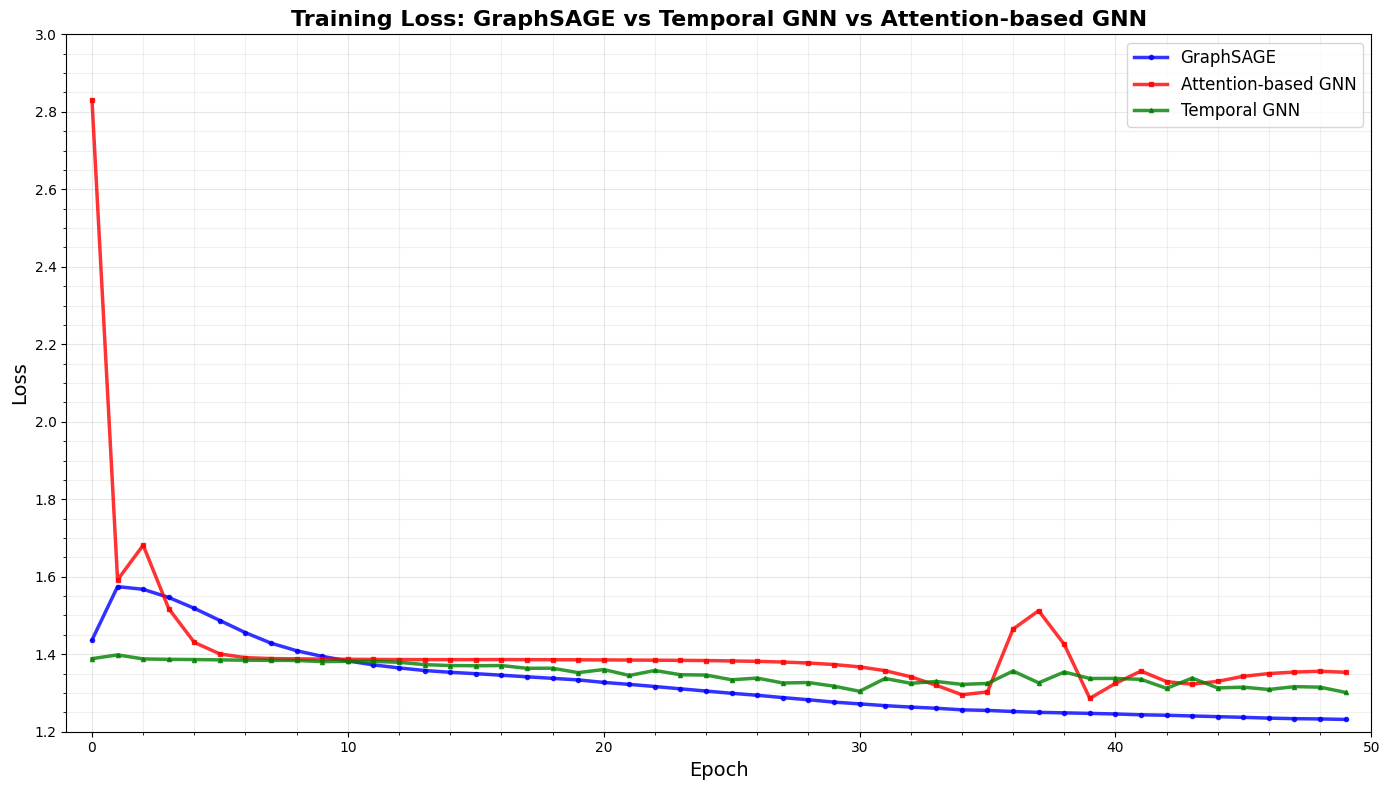

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Training data extracted from your logs
epochs = list(range(50))

# GraphSAGE losses
graphsage_losses = [1.4366,1.5745,1.5676,1.5465,1.5185,1.4870,1.4556,1.4286,1.4090,1.3945,
                    1.3827,1.3725,1.3647,1.3580,1.3534,1.3498,1.3459,1.3417,1.3378,1.3337,
                    1.3273,1.3222,1.3167,1.3107,1.3050,1.2992,1.2941,1.2881,1.2825,1.2764,
                    1.2719,1.2673,1.2636,1.2606,1.2565,1.2550,1.2522,1.2500,1.2487,1.2473,
                    1.2458,1.2437,1.2425,1.2407,1.2389,1.2371,1.2351,1.2337,1.2330,1.2317]

# AttentionGNN losses
attention_losses = [2.8303,1.5919,1.6814,1.5177,1.4305,1.4007,1.3912,1.3888,1.3881,1.3875,
                    1.3870,1.3866,1.3862,1.3861,1.3860,1.3861,1.3862,1.3860,1.3858,1.3856,
                    1.3853,1.3850,1.3846,1.3842,1.3837,1.3827,1.3817,1.3798,1.3774,1.3734,
                    1.3674,1.3576,1.3418,1.3199,1.2954,1.3027,1.4648,1.5124,1.4255,1.2861,
                    1.3247,1.3566,1.3293,1.3226,1.3301,1.3430,1.3501,1.3540,1.3561,1.3534]

# TemporalGNN losses
temporal_losses = [1.3886,1.3983,1.3879,1.3868,1.3863,1.3854,1.3846,1.3842,1.3840,1.3809,
                   1.3818,1.3815,1.3792,1.3732,1.3708,1.3703,1.3708,1.3637,1.3639,1.3525,
                   1.3605,1.3452,1.3581,1.3471,1.3463,1.3341,1.3384,1.3258,1.3269,1.3176,
                   1.3044,1.3374,1.3250,1.3297,1.3222,1.3246,1.3566,1.3262,1.3541,1.3374,
                   1.3376,1.3352,1.3119,1.3384,1.3130,1.3150,1.3090,1.3164,1.3150,1.3014]

# Create the plot
plt.figure(figsize=(14, 8))

plt.plot(epochs, graphsage_losses, 'b-', label='GraphSAGE', linewidth=2.5, marker='o', markersize=3, alpha=0.8)
plt.plot(epochs, attention_losses, 'r-', label='Attention-based GNN', linewidth=2.5, marker='s', markersize=3, alpha=0.8)
plt.plot(epochs, temporal_losses, 'g-', label='Temporal GNN', linewidth=2.5, marker='^', markersize=3, alpha=0.8)

# Customize the plot
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss: GraphSAGE vs Temporal GNN vs Attention-based GNN', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set axis limits for better visualization
plt.xlim(-1, 50)
plt.ylim(1.2, 3.0)  # Adjusted for the high initial AttentionGNN loss

# Add minor ticks
plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)

plt.tight_layout()
plt.show()

